<a href="https://colab.research.google.com/github/GreggHeller1/Neuron_Tutorial/blob/main/scripts/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# settings
%load_ext autoreload
%autoreload 2
try:
    import google.colab

    in_colab = True
except:
    in_colab = False
print(in_colab)

False


In [4]:
# installs (for colab only, run this once)
if in_colab:
    ! git clone https://github.com/GreggHeller1/PMT_linearization.git

In [6]:
# local imports
# cwd if in colab for imports to work
if in_colab:
    %cd /content/PMT_linearization

from src import data_io as io
from src import plotting
from src import computation as comp
from src import main
from datetime import datetime


In [147]:
# imports
from matplotlib import pyplot as plt
import os
import numpy as np
from collections import OrderedDict

In [8]:
# define paths
# cwd if in colab for file loading to work
if in_colab:
    %cd /content/PMT_linearization/scripts

test_path = os.path.join("demo_data", "test.txt")
print(test_path)
print(os.getcwd())
os.path.exists(test_path)

demo_data/test.txt
/Users/Gregg/code/PMT_linearization


False

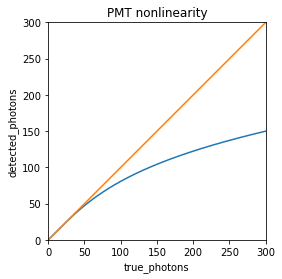

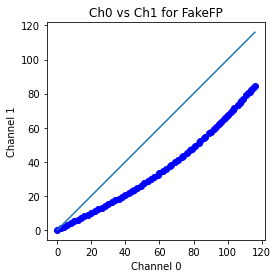

In [9]:
fp = "FakeFP"
x = np.arange(0, 350)
x, y = comp.fake_pmt_n(x)
fig, ax = plotting.plot_pmt_nonlinearity(x, y)


fake_ratio = 2.0
fake_true_photons, fake_green_channel = comp.fake_pmt_n(np.arange(0, 140, fake_ratio))

fake_x2, fake_red_channel = comp.fake_pmt_n(fake_true_photons / fake_ratio, round=False)
channel_i = 0
channel_j = 1
fig, ax, title = plotting.plot_channels(
    fake_green_channel, fake_red_channel, channel_i, channel_j, alpha=1, label=fp
)
io.savefig(fig, title)

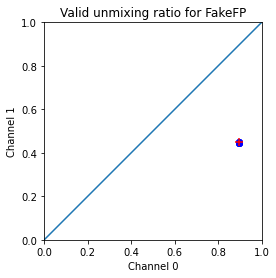

1.9974176203716936
[0.8944271909999159, 0.8944271909999159, 0.8944173755046528, 0.8943388437914351, 0.8941817390824464, 0.8939459790846706, 0.8936314410381386] [0.4472135954999579, 0.4472135954999579, 0.4472332259519287, 0.44739024630159197, 0.44770416291507936, 0.4481747276212145, 0.4488015681658208]


In [10]:
# data manipulation

xs, ys, xs_per_y = comp.get_unmixing_ratio(fake_green_channel, fake_red_channel)
fig, ax, title = plotting.plot_unmixing_vectors(
    xs, ys, channel_i, channel_j, label=fp, plot=True
)
io.savefig(fig, title)
print(xs_per_y)
print(xs, ys)

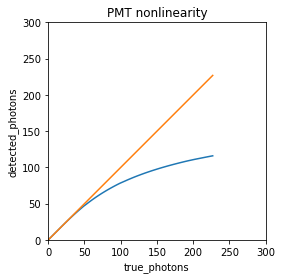

In [11]:
detected_photons, true_photons = comp.compute_PMT_nonlinearity(
    fake_green_channel, fake_red_channel, xs_per_y
)
io.save_PMT_curve(detected_photons, true_photons, i=channel_i, j=channel_j, fp=fp)


# Plot the inferred nonlinearity and see if it matches
fig, ax = plotting.plot_pmt_nonlinearity(true_photons, detected_photons)
io.savefig(fig, f"PMT curve from {fp} on {channel_i}{channel_j}")

116.0 84.53704584746592


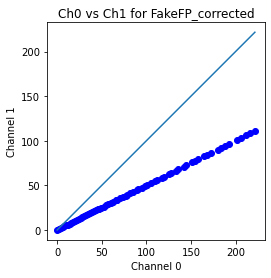

In [12]:
# use the inferred nonlinearity to correct both channels then plot. The result should be linear
corrected_green = []
corrected_red = []

for g, r in zip(fake_green_channel, fake_red_channel):
    try:
        corrected_green.append(
            comp.correct_PMT_nonlinearity(g, detected_photons, true_photons)
        )
        corrected_red.append(
            comp.correct_PMT_nonlinearity(r, detected_photons, true_photons)
        )
    except Exception as E:
        print(g, r)

fig, ax, title = plotting.plot_channels(
    corrected_green,
    corrected_red,
    channel_i,
    channel_j,
    alpha=1,
    label=f"{fp}_corrected",
)
io.savefig(fig, title)

In [13]:
# Now lets do it with an image of actual flourophores

filename = (
    "TDTfp_only.tif"  # "TFP_10us_dwell_915nm_Z_STACK.tiff"#"YFP_10us__STACK.tiff"#
)
filepath = os.path.join("scripts","demo_data", filename)
os.path.exists(filepath)


im = io.imread(filepath)
fp = comp.fp_from_tiffname(filename)

for i in range(im.shape[3]):
    for j in range(im.shape[3]):
        if not (i == j):
            try:
                main.main(
                    fp,
                    i,
                    j,
                    im[:, :, :, i].flatten(),
                    im[:, :, :, j].flatten(),
                    alpha=0.01,
                )
            except Exception as E:
                pass

FileNotFoundError: [Errno 2] No such file or directory: 'scripts/demo_data/TDTfp_only.tif'

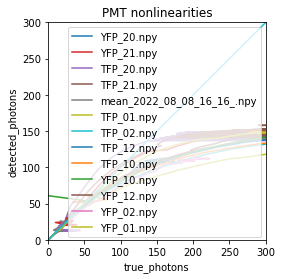

In [15]:

curve_dict = io.load_PMT_curves()
fig, ax = plotting.plot_PMT_curves(curve_dict)
io.savefig(fig, f"PMT_nonlinearities from {fp}")

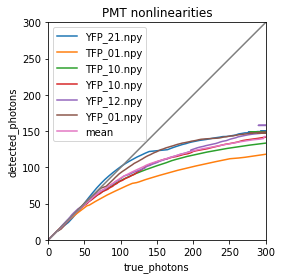

In [16]:
# use 0,1 YFP, 12, YFP, 01 TFP Only
valid_curves = io.load_valid_curve_json()

valid_curves["YFP_01.npy"] = True
valid_curves["YFP_01.npy"] = True
valid_curves["TFP_01.npy"] = True
valid_curves["TFP_10.npy"] = True
valid_curves["YFP_12.npy"] = True
valid_curves["YFP_21.npy"] = True


to_plot = {}
for key, value in valid_curves.items():
    if value:
        to_plot[key] = curve_dict[key]
mean_curve = comp.get_average_curve(to_plot)
to_plot['mean'] = mean_curve

fig, ax = plotting.plot_PMT_curves(to_plot)

io.save_valid_curve_json(current_valid_dict=valid_curves, all_curves=curve_dict)
#io.save_mean_PMT_curve(mean_curve['counts'], mean_curve['corrections'])



In [33]:
#Now we can run the linearization on all the images

unmixing_images = ['TDTfp_only.tiff', 'YFP_10us__STACK.tiff', 'TFP_10us_dwell_915nm_Z_STACK.tiff']

#load the master PMT curve

#for imagename in unmixing_images:
    
    #filepath = os.path.join("scripts", "demo_data", imagename)
    
filepath = "/Users/Gregg/Dropbox (MIT)/Unmixing Code for Gregg/Test4c"
im = io.imread(filepath)
fp = 'test4c'#comp.fp_from_tiffname(imagename)
savepath = os.path.join("scripts", "demo_data", f'{fp}_original.tiff')
io.write_4d_tiff(im, savepath)
print('Now linearizing {imagename}')
lin_im = comp.linearize_image(im)

savepath = filepath = io.get_linear_tiff_path(fp)
io.write_4d_tiff(lin_im.astype(np.int16), savepath)





Now linearizing {imagename}


NameError: name 'io' is not defined

In [17]:
#Check if the linearization worked
#filename = (
#    "YFP_linear.tiff"  # "TFP_10us_dwell_915nm_Z_STACK.tiff"#"YFP_10us__STACK.tiff"#
#)
#filepath = os.path.join("scripts","demo_data", filename)
#fp = comp.fp_from_tiffname(filename)

fp = "YFP"
filepath = io.get_linear_tiff_path(fp)

os.path.exists(filepath)

im = io.imread(filepath)

for i in range(im.shape[3]):
    for j in range(im.shape[3]):
        if not (i == j):
            try:
                main.main_scatter_only(
                    f'{fp}_linear',
                    i,
                    j,
                    im[:, :, :, i].flatten(),
                    im[:, :, :, j].flatten(),
                    alpha=0.01,
                )
            except Exception as E:
                pass

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Gregg/code/PMT_linearization/scripts/data/YFP_linear.tiff'

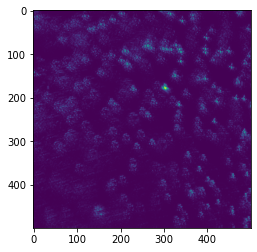

In [ ]:
#Now lets calciulate the unmixing coefficients from the linearized images
    

#linear_unmixing_images = ['TDTfp_linear.tiff', 'YFP_linear.tiff', 'TFP_linear.tiff']
fp_list = ['TDTfp', 'YFP', 'TFP' ]

#for imagename in linear_unmixing_images:
    #filepath = os.path.join("scripts", "demo_data", imagename)
for fp in fp_list:
    filepath = io.get_linear_tiff_path(fp)
    im = io.imread(filepath)
    #fp = comp.fp_from_tiffname(imagename)
    print(fp)
    coefs = comp.get_unmixing_coefs(im)

    savepath = io.get_coef_path(fp)
    io.save_coefs(savepath, coefs)   


['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


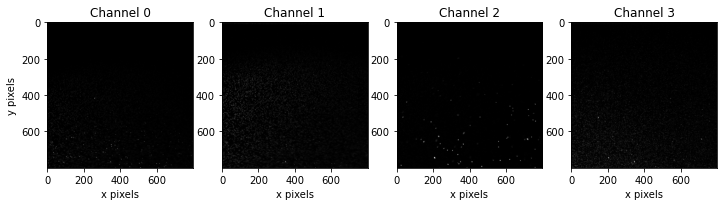

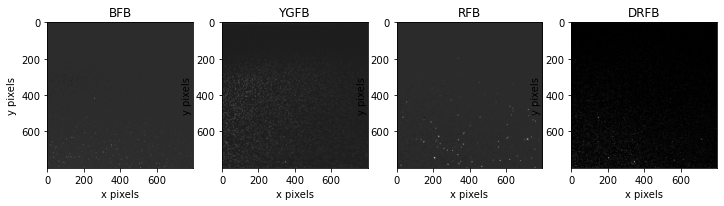

In [46]:

im.shape
plt.imshow(im[0,:,:,3])


['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


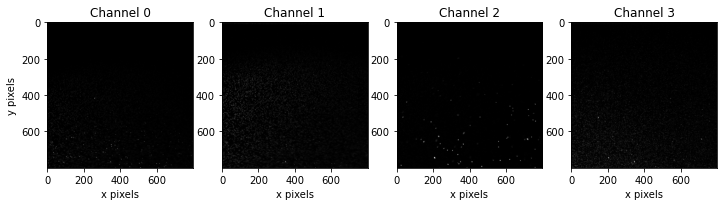

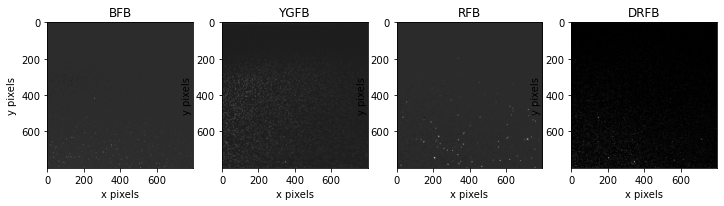

In [ ]:

example_path = "/Users/Gregg/code/PMT_linearization/scripts/demo_data/stack_4color.tif"

ex_im, ex_tags = io.imread(example_path)



['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


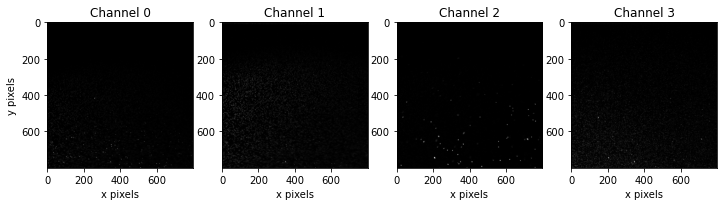

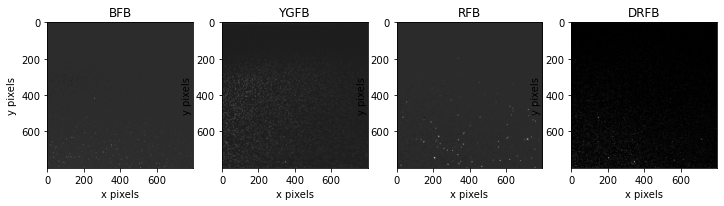

['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


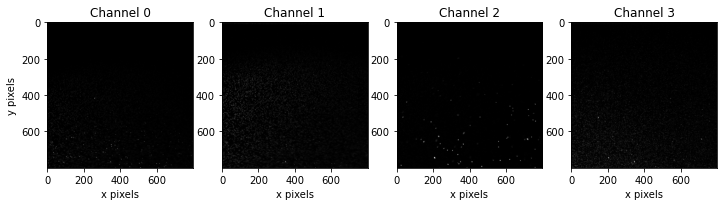

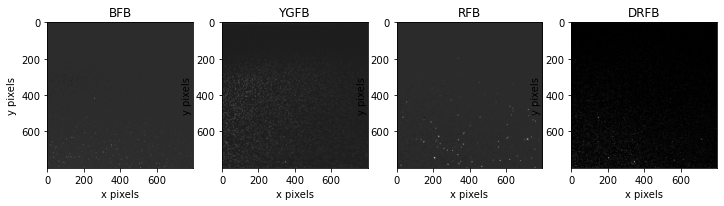

In [201]:


def get_unmixing_matrix(coef_dict):
    unmixing_matrix = []
    for coef in coef_dict.values():
        unmixing_matrix.append(coef)
        
    return np.array(unmixing_matrix)



def get_mock_image(unmixing_matrix):
    mock_image = np.tile(unmixing_matrix.T, (10,1))
    #print(mock_image.shape)
    mock_image = np.tile(mock_image, (7,40,1,1))
    return mock_image

#print(mock_image.shape)
#first_pix = mock_image[0,0,0,:]
#print(f'First pixel {first_pix}')
#x_inferred, res, rank, s = np.linalg.lstsq(unmixing_matrix, first_pix)
#print(f'First pixel unmixed {x_inferred}')

def plot_seperate_channels(im, labels=None, slice=0):
    if labels is None:
        labels = [f'Channel {i}' for i in range(num_channels)]
    fig,ax = plt.subplots(1,im.shape[3], figsize=(12, 6))
    for i in range(num_channels):
        ax[i].imshow(im[0,:,:,i], cmap='gray')
        ax[i].set_title(labels[i])
        ax[i].set_xlabel(f'x pixels')
        ax[i].set_ylabel(f'y pixels')
    return fig, ax


def unmix(unmixing_mat, im):
    (slices, x_pixels, y_pixels, channels) = im.shape
    b = np.reshape(im, (slices*x_pixels*y_pixels, channels), order='F').T
    #print(b.shape)
    #print(b[:,0:6])
    A = unmixing_mat
    #print(A.shape)
    x_inferred, res, rank, s = np.linalg.lstsq(A, b, rcond=None)
    unmixed_im = np.reshape(x_inferred.T, (slices, x_pixels, y_pixels, channels), order='F')
    #res_im = np.reshape(res, (slices, x_pixels, y_pixels, channels), order='C')
    return unmixed_im, res, rank

def unmixing_with_plots(im, coef_dict, slice=0):
    unmixing_matrix = get_unmixing_matrix(coef_dict)
    num_fps = unmixing_matrix.shape[1]
    num_unmixing_channels = unmixing_matrix.shape[0]
    num_im_channels = im.shape[3]
    assert(num_unmixing_channels == num_im_channels)
    print(f'Num fps: {num_fps}')
    print(f'Num channels: {num_channels}')
    unmixed_im, res, rank = unmix(unmixing_matrix, im)
    plot_before_after_unmixing(im, unmixed_im, unmixed_labels=list(coef_dict.keys()), slice=slice)
    return unmixed_im, res, rank

def plot_before_after_unmixing(og_im, unmixed_im, og_labels=None, unmixed_labels=None, slice=0):
    plot_seperate_channels(og_im, labels=og_labels, slice=slice)
    plot_seperate_channels(unmixed_im, labels=unmixed_labels,  slice=slice)

def main_unmixing(im, coef_dict, save_dir=None,  save_original=True, unmixing=True):
    if save_dir is None:
        pass
    
    print(im.shape)
    if save_original:
        save_slices(im, label='original')
    if unmixing:
        unmixed_im, res, rank = unmixing_with_plots(im, coef_dict)
        print(unmixed_im.shape)
        save_slices(unmixed_im, label='unmixed')
    return im, unmixed_im, res, rank
        
def save_slices(og_im, label=''):
    for slice in range(og_im.shape[0]):
        for channel in range(og_im.shape[3]):
            print(f'channel: {channel}, slice: {slice}')
            base_path = '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo'
            savepath = os.path.join(base_path, f'{fp}{channel}{slice}_{label}.tiff')
            print(savepath)
            io.write_4d_tiff(og_im[slice,:,:,channel], savepath, imagej=False)
        


['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


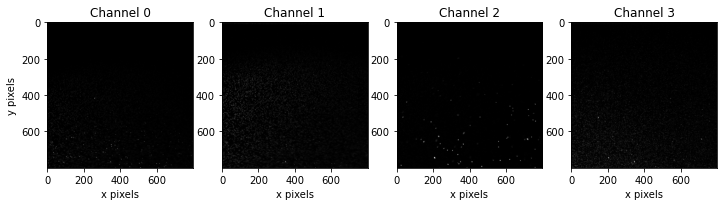

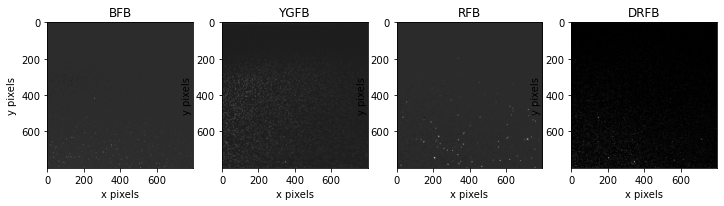

In [179]:
original_path = "/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/4C/4C_Run1_10us"
og_im, og_tags = io.imread(original_path)

coef_dict = OrderedDict()
coef_dict['BFB'] = [ 0.62 , 0.33 , 0.03, 0.01 ]
coef_dict['YGFB'] = [0.18 , 0.74 , 0.066, 0.013]
coef_dict['RFB'] = [0 , 0 , .8, 0.2]
coef_dict['DRFB'] = [0, 0, 0, 1]

mock_image = get_mock_image(unmixing_matrix)
unmixed_im, res, rank = unmixing_with_plots(mock_image, coef_dict)


['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


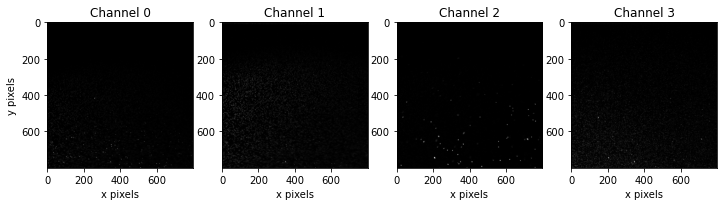

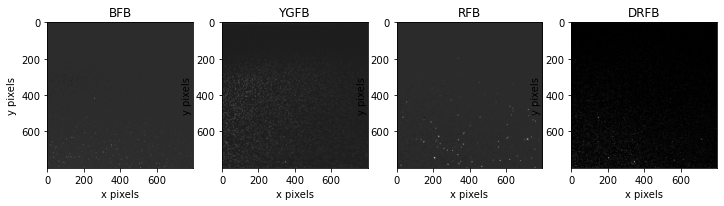

In [ ]:

beads4c_original_path = "/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/4C/4C_Run1_10us"
im, tags = io.imread(beads4c_original_path)

og_im, unmixed_im, res, rank = main_unmixing(im, coef_dict, save_dir=None,  save_original=False, unmixing=True)


['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


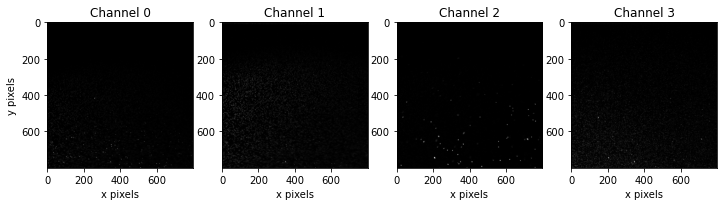

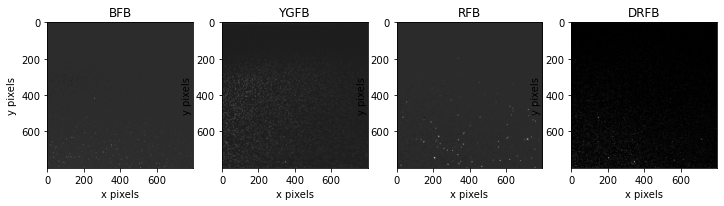

In [ ]:

bead_list = ['BFB', 'YGFB', 'RFB', 'DRFB']
path_list = [f"/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/{bead}_Composite.tif" for bead in bead_list]
print(path_list)

image_list = [np.array([io.imread(im_path)[0]]) for im_path in path_list]
print(image_list[0].shape)
combined_image = np.zeros(image_list[0].shape)
for im in image_list:
    combined_image = combined_image+im

og_im, unmixed_im, res, rank = main_unmixing(combined_image, coef_dict, save_dir=None,  save_original=True, unmixing=True)


['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


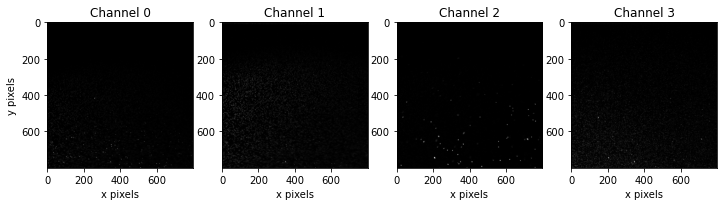

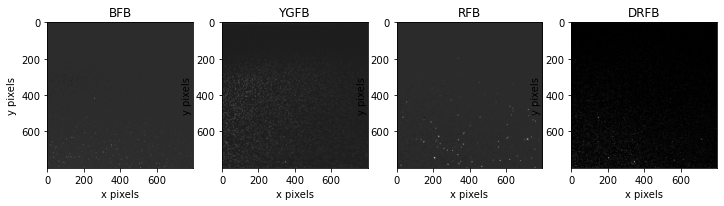

In [190]:

plot_before_after_unmixing(og_im, unmixed_im, unmixed_labels=list(coef_dict.keys()), slice=2)

['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


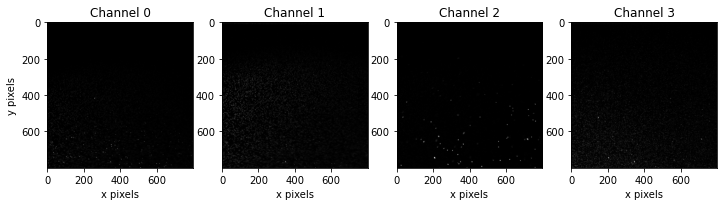

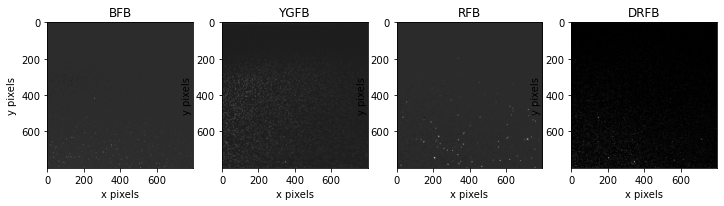

In [99]:
print(unmixed_im.shape)

print(unmixed_im.shape[3])
fp = 'beads4c'

def save_slices(og_im, label='unmixed')
    for slice in range(og_im.shape[0]):
        for channel in range(og_im.shape[3]):
            print(channel)
            print(slice)
            savepath = os.path.join(base_path, f'{fp}{channel}{slice}_{label}.tiff')
            io.write_4d_tiff(og_im[slice,:,:,channel], savepath, imagej=False)
        
plt.imshow(unmixed_im[2,:,:,2])    

['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


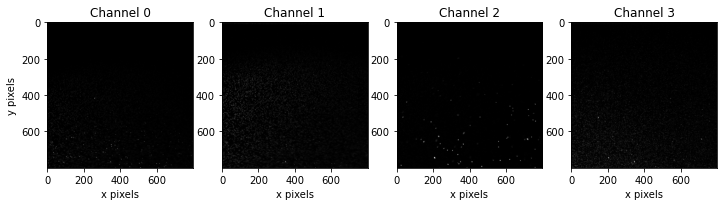

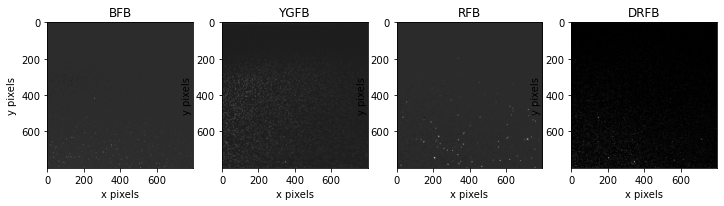

In [76]:
base_path = "/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/"

path_dict = {
    'RFB': "/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/Red/red_run1_10us",
    'DRFB': "/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/Dark red/darkred_10us_run1",
    'BFB': "/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/Blue/run1_10us",
    'YGFB': "/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/Yellowgreen/run1_10us_yellow",
}

for fb, fb_path in path_dict.items():
    print(fb)
    filepath = fb_path
    im, tags = io.imread(filepath)
    print(im.shape)
    fp = fb#'test4c'#comp.fp_from_tiffname(imagename)
    
    description = ex_tags['ImageDescription']
    channels = im.shape[3]
    slices = im.shape[0]
    print(channels, slices)
    
    #ex_tags['ImageDescription'].replace('images=68', f'images={channels*slices}')
    #ex_tags['ImageDescription'].replace('slices=17', f'slices={slices}')
    #ex_tags['ImageDescription'].replace('channels=4', f'channels={channels}')
    for channel in range(im.shape[3]):
        savepath = os.path.join(base_path, f'{fp}{channel}_original.tiff')
        io.write_4d_tiff(im[0,:,:,channel], savepath)#, IJMetadata=ex_tags['IJMetadata'], ImageDescription= description)
    #print('Now linearizing {imagename}')
    #lin_im = comp.linearize_image(im)
    
    #savepath = os.path.join(base_path, f'{fp}_linear.tiff')
    #io.write_4d_tiff(lin_im.astype(np.int16), savepath)


['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


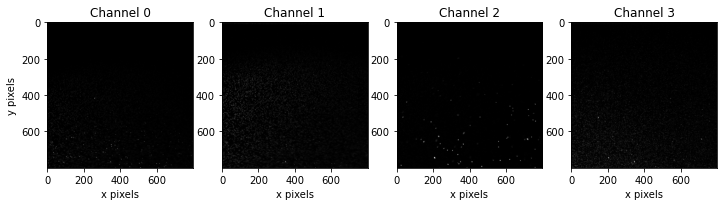

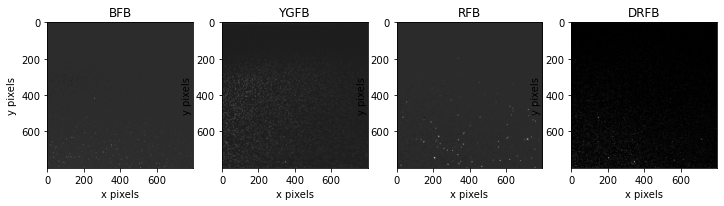

In [53]:

print(ex_im.shape)

['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


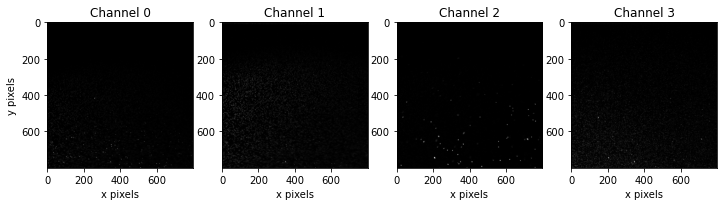

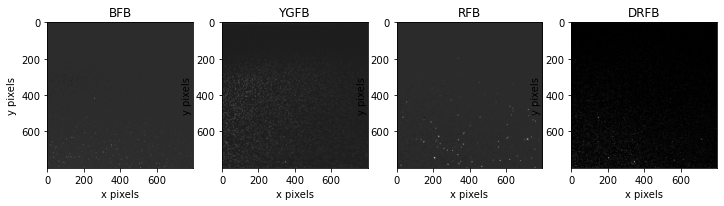

In [59]:



print(ex_tags.keys())

print(ex_tags['ImageDescription'].replace('slices=17', 'slices=16'))
print(ex_tags['IJMetadata'])


['/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/BFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/YGFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/RFB_Composite.tif', '/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/DRFB_Composite.tif']
(1, 800, 800, 4)
(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_original.tiff


channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_original.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_original.tiff
channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_original.tiff
Num fps: 4
Num channels: 4


(1, 800, 800, 4)
channel: 0, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c00_unmixed.tiff
channel: 1, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c10_unmixed.tiff
channel: 2, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c20_unmixed.tiff


channel: 3, slice: 0
/Users/Gregg/Dropbox (MIT)/For Gregg/Gregg_Kendyll_unmixing/synthetic_combo/beads4c30_unmixed.tiff


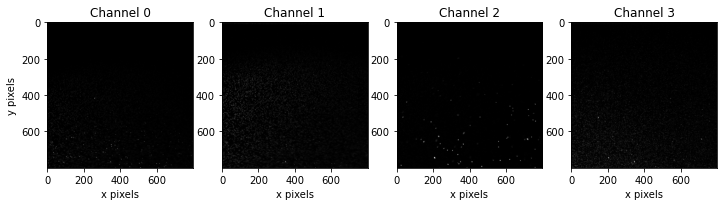

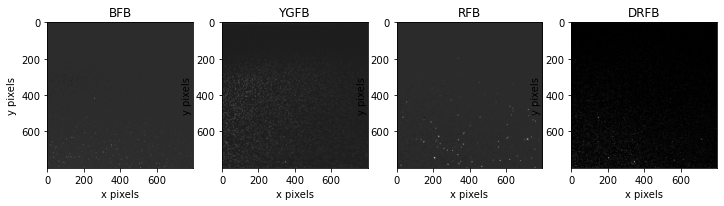

In [29]:
#now to do the unmixing

filepath = "/Users/Gregg/Dropbox (MIT)/Files for Gregg/FromJoe/4color_testing/unmixingcoeffs/tdTomato_invivo_run2_10usdwell_915nm_700mWbeforeobject/rawtif/run2_10usdwell_915nm_700mWbeforeobject__STACK.tiff"

im = io.imread(filepath)

unmixing_mat = io.get_unmixing_mat()

unmixed_im = comp.unmix(unmixing_mat, im)

savepath = filepath = io.get_unmix_tiff_path(fp)
io.write_4d_tiff(unmixed_im.astype(np.int16), savepath)





In [ ]:

x = 2**1000
print()
print('{:.2e}'.format(x))

x = (2**150)*(2**850)
print()
print(x)

print('{:.2e}'.format(x))

from math import comb
x=comb(700,7)*comb(300,3)

print('{:.2e}'.format(x))

10715086071862673209484250490600018105614048117055336074437503883703510511249361224931983788156958581275946729175531468251871452856923140435984577574698574803934567774824230985421074605062371141877954182153046474983581941267398767559165543946077062914571196477686542167660429831652624386837205668069376
1.07e+301


In [128]:
funclist = [lambda x: x, lambda x: x**2]
x = np.array([1, 2, 3, 4, 5])
np.piecewise(x, [x < 3, x >= 3], funclist)

array([ 1,  2,  9, 16, 25])

In [137]:
np.searchsorted(x, y) - 1

array([-1,  0,  1,  2,  3,  4,  4,  4,  4,  4])

In [25]:
y[np.logical_and(y > 3, y < 7)]

array([4, 5, 6])

In [28]:

path = "/Users/Gregg/Dropbox (MIT)/Files for Gregg/FromJoe/4color_testing/unmixingcoeffs/YFP_915/10us_dwell_915nm/YFP_10us__STACK_OG.tiff"
im = io.imread(path)



from src import config as cfg

def get_unmixing_coefs(im_array, min_pixel=0, max_pixel=np.inf):
    
    #identify the axis for color channel
    channel_axis = im_array.shape.index(cfg.num_channels)
    #TODO add handling for if multiple dimensions match
    
    print(im_array.shape)
    print(im_array.shape.index(cfg.num_channels))
    
    
    #mask out all the invalidvalid values
    mask = np.logical_or(im_array<min_pixel, im_array>max_pixel)
    #mask will be 1 when its bad in any channel
    
    pixel_mask = np.max(mask, axis=0)
    #mask will be 1 when its bad in any channel
    
    pixel_mask = np.invert(pixel_mask)
    #mask will be 1 if no pixels in any channel are bad

    valid_idxs = np.nonzero(pixel_mask)[0]
    #indicies of pixels we want to keep
    
    #roll the axis so the channels are the first axis so the following syntax works
    rolled_im = np.rollaxis(im_array, channel_axis)
    
    #get all the valid pixels
    valid_pixels = rolled_im[:,valid_idxs]
    
    #flatten it to just 2 dimensions? channel and value
    flat_pixels = valid_pixels.reshape(num_channels,-1)

    #find the channel with the highes max/most variance 
    max_chan = np.argmax(np.var(flat_pixels, axis=-1))

    #then divide all values by that of the max channel
    normalized_pixels = flat_pixels/flat_pixels[max_chan]
    #we can plot all these if we want
    
    #finally average them ALL
    median = np.median(normalized_pixels, axis=-1)
    return coefs, normalized_pixels
    
#get_unmixing_coefs(im, cfg.range_min, cfg.range_max)

a = np.array([[0,1,2,3,4,5,6],[6,5,4,6,3,6,3], [3,3,3,3,3,3,3]])
#First generate the mask of high and low. 
mask = np.logical_and(a<6, a>2)
# Sum along the channel axis. 
mask = np.sum(mask, axis=0)
print(mask)
#then concatenate to the right size and apply mask
np.tile(b, cfg.num_channels)

#print(im_1.find(3))
#plt.imshow(im_1[0, :, :, 1])
#print(im_1[6, :, :, 2])
#print(type(im_1[0,0,0,0]))


[1 2 2 2 3 2 2]


NameError: name 'b' is not defined

there
(15, 400, 400, 3)
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]
<class 'numpy.int16'>


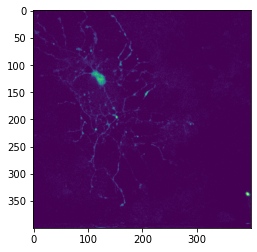

In [54]:
path_ = "/Users/Gregg/Dropbox (MIT)/Files for Gregg/FromJoe/4color_testing/unmixingcoeffs/YFP_915/10us_dwell_915nm"  #"/Users/Gregg/Dropbox (MIT)/Files for Gregg/FromJoe/4color_testing/unmixingcoeffs/tdTomato_invivo_run2_10usdwell_915nm_700mWbeforeobject/rawtif/run2_10usdwell_915nm_700mWbeforeobject__STACK.tiff"

#print(sorted(os.listdir(path_)))
          
        

im = io.imread(path_)
print(im.shape)

name = 'test_save.ome.tiff'
save_path = os.path.join(os.path.split(path)[0], name)
print(im[6, :, :, 2])

io.write_4d_tiff(im, save_path)
plt.imshow(im[11, :, :, 1])


print(type(im[0,0,0,0]))


In [51]:
(im==im_1).all()

True

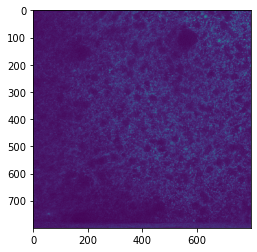

In [140]:
plt.imshow(cropped[:, :, 2])

In [141]:
from mpl_toolkits.mplot3d import Axes3D

(10000, 3)


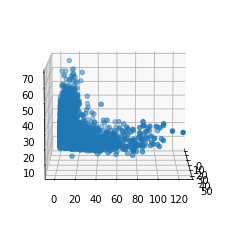

In [155]:
valid_mask = cropped[:, :, 2] > 4
cropped_nonzero = cropped[valid_mask, :]
a = np.arange(0, cropped_nonzero.shape[0], 1)
subsample = np.random.choice(a, 10000)
subsampled = cropped_nonzero[subsample, :]
print(subsampled.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(cropped_nonzero[:, 0], cropped_nonzero[:, 1], cropped_nonzero[:, 2])
ax.view_init(elev=10.0, azim=0)

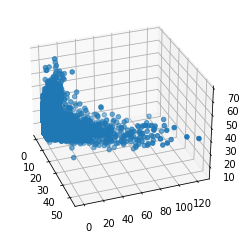

In [158]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(cropped_nonzero[:, 0], cropped_nonzero[:, 1], cropped_nonzero[:, 2])
ax.view_init(elev=30.0, azim=-20)

In [173]:
mask = cropped[:, :, 2] < 4 * cropped[:, :, 0]
cropped[mask] = 0

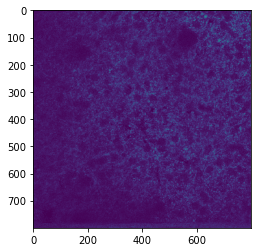

In [179]:
plt.imshow(cropped[:, :, 2])

(10000, 3)


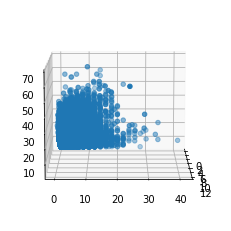

In [178]:
valid_mask = cropped[:, :, 2] > 4
cropped_nonzero = cropped[valid_mask, :]
a = np.arange(0, cropped_nonzero.shape[0], 1)
subsample = np.random.choice(a, 10000)
subsampled = cropped_nonzero[subsample, :]
print(subsampled.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(cropped_nonzero[:, 0], cropped_nonzero[:, 1], cropped_nonzero[:, 2])
ax.view_init(elev=10.0, azim=0)

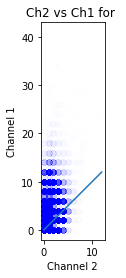

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Ch2 vs Ch1 for '}, xlabel='Channel 2', ylabel='Channel 1'>,
 'Ch2 vs Ch1 for ')

In [194]:
plotting.plot_channels(cropped[:, :, 0], cropped[:, :, 1], 2, 1, alpha=0.002)